In [1]:
import quandl
import zipline
import pandas as pd
from zipline.api import record, symbol, order_target_percent, order
from zipline import run_algorithm
from zipline.finance import commission, slippage
from datetime import datetime
import pytz
import pyfolio as pf


In [2]:
# silence warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
%load_ext zipline


In [12]:
%zipline --start=2004-1-1 --end=2010-1-1 -b quantopian-quandl -o results.pickle
#%%zipline --start 2004-1-1 --end 2010-1-1 -o results.pickle



,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2004-01-02 21:00:00+00:00,NaN,0.000000,NaN,0.004463,NaN,NaN,0.00,1.000000e+07,0.000000e+00,0.000000e+00,...,0.0,0.0,0,NaN,1.000000e+07,0.000000e+00,0.000000e+00,1,[],0.0
2004-01-05 21:00:00+00:00,0.000000,0.000000,NaN,0.008945,0.000000,NaN,-10126240.51,-1.262405e+05,1.012624e+07,1.012624e+07,...,0.0,0.0,0,NaN,1.000000e+07,0.000000e+00,0.000000e+00,2,"[{'dt': 2004-01-05 21:00:00+00:00, 'order_id':...",0.0
2004-01-06 21:00:00+00:00,0.072181,0.007876,NaN,0.013448,0.000000,NaN,109847.75,-1.639276e+04,1.009515e+07,1.009515e+07,...,0.0,0.0,0,NaN,-1.262405e+05,1.012624e+07,1.012624e+07,3,"[{'dt': 2004-01-06 21:00:00+00:00, 'order_id':...",0.0
2004-01-07 21:00:00+00:00,0.064697,0.013910,NaN,0.017971,0.000000,NaN,38098.34,2.170558e+04,1.011740e+07,1.011740e+07,...,0.0,0.0,0,NaN,-1.639276e+04,1.009515e+07,1.009515e+07,4,"[{'dt': 2004-01-07 21:00:00+00:00, 'order_id':...",0.0
2004-01-08 21:00:00+00:00,0.202046,-0.010300,NaN,0.022513,0.000000,NaN,15955.16,3.766074e+04,9.859341e+06,9.859341e+06,...,0.0,0.0,0,-2.977554,2.170558e+04,1.011740e+07,1.011740e+07,5,"[{'dt': 2004-01-08 21:00:00+00:00, 'order_id':...",0.0
2004-01-09 21:00:00+00:00,0.181404,-0.009871,NaN,0.027077,0.000000,NaN,-35493.79,2.166950e+03,9.899121e+06,9.899121e+06,...,0.0,0.0,0,-2.600576,3.766074e+04,9.859341e+06,9.859341e+06,6,"[{'dt': 2004-01-09 21:00:00+00:00, 'order_id':...",0.0
2004-01-12 21:00:00+00:00,0.169354,-0.005599,NaN,0.031660,0.000000,NaN,-3383.39,-1.216440e+03,9.945227e+06,9.945227e+06,...,0.0,0.0,0,-1.323460,2.166950e+03,9.899121e+06,9.899121e+06,7,"[{'dt': 2004-01-12 21:00:00+00:00, 'order_id':...",0.0
2004-01-13 21:00:00+00:00,0.162138,-0.013664,NaN,0.036264,0.000000,NaN,-622.71,-1.839150e+03,9.865204e+06,9.865204e+06,...,0.0,0.0,0,-2.977182,-1.216440e+03,9.945227e+06,9.945227e+06,8,"[{'dt': 2004-01-13 21:00:00+00:00, 'order_id':...",0.0
2004-01-14 21:00:00+00:00,0.156543,-0.008086,NaN,0.040889,0.000000,NaN,231.70,-1.607450e+03,9.920746e+06,9.920746e+06,...,0.0,0.0,0,-1.620372,-1.839150e+03,9.865204e+06,9.865204e+06,9,"[{'dt': 2004-01-14 21:00:00+00:00, 'order_id':...",0.0
2004-01-15 21:00:00+00:00,0.147731,-0.010212,NaN,0.045534,0.000000,NaN,-2959.58,-4.567030e+03,9.902449e+06,9.902449e+06,...,0.0,0.0,0,-1.956761,-1.607450e+03,9.920746e+06,9.920746e+06,10,"[{'dt': 2004-01-15 21:00:00+00:00, 'order_id':...",0.0


In [13]:
STOCKS = ['AMD', 'CERN', 'COST', 'DELL', 'GPS', 'INTC', 'MMM']


In [14]:
# On-Line Portfolio Moving Average Reversion

# More info can be found in the corresponding paper:
# http://icml.cc/2012/papers/168.pdf
def initialize(algo, eps=1, window_length=5):
    algo.stocks = STOCKS
    algo.sids = [algo.symbol(symbol) for symbol in algo.stocks]
    algo.m = len(algo.stocks)
    algo.price = {}
    algo.b_t = np.ones(algo.m) / algo.m
    algo.eps = eps
    algo.window_length = window_length

    algo.set_commission(commission.PerShare(cost=0))
    algo.set_slippage(slippage.FixedSlippage(spread=0))


In [15]:
def handle_data(algo, data):
    m = algo.m

    x_tilde = np.zeros(m)
    b = np.zeros(m)

    # find relative moving average price for each asset
    mavgs = data.history(algo.sids, 'price', algo.window_length, '1d').mean()
    for i, sid in enumerate(algo.sids):
        price = data.current(sid, "price")
        # Relative mean deviation
        x_tilde[i] = mavgs[sid] / price

    ###########################
    # Inside of OLMAR (algo 2)
    x_bar = x_tilde.mean()

    # market relative deviation
    mark_rel_dev = x_tilde - x_bar

    # Expected return with current portfolio
    exp_return = np.dot(algo.b_t, x_tilde)
    weight = algo.eps - exp_return
    variability = (np.linalg.norm(mark_rel_dev)) ** 2

    # test for divide-by-zero case
    if variability == 0.0:
        step_size = 0
    else:
        step_size = max(0, weight / variability)

    b = algo.b_t + step_size * mark_rel_dev
    b_norm = simplex_projection(b)
    np.testing.assert_almost_equal(b_norm.sum(), 1)

    rebalance_portfolio(algo, data, b_norm)

    # update portfolio
    algo.b_t = b_norm


In [16]:
def rebalance_portfolio(algo, data, desired_port):
    # rebalance portfolio
    for i, sid in enumerate(algo.sids):
        algo.order_target_percent(sid, desired_port[i])


In [17]:


def simplex_projection(v, b=1):
    """Projection vectors to the simplex domain
    Implemented according to the paper: Efficient projections onto the
    l1-ball for learning in high dimensions, John Duchi, et al. ICML 2008.
    Implementation Time: 2011 June 17 by Bin@libin AT pmail.ntu.edu.sg
    Optimization Problem: min_{w}\| w - v \|_{2}^{2}
    s.t. sum_{i=1}^{m}=z, w_{i}\geq 0
    Input: A vector v \in R^{m}, and a scalar z > 0 (default=1)
    Output: Projection vector w
    :Example:
    >>> proj = simplex_projection([.4 ,.3, -.4, .5])
    >>> print(proj)
    array([ 0.33333333, 0.23333333, 0. , 0.43333333])
    >>> print(proj.sum())
    1.0
    Original matlab implementation: John Duchi (jduchi@cs.berkeley.edu)
    Python-port: Copyright 2013 by Thomas Wiecki (thomas.wiecki@gmail.com).
    """

    v = np.asarray(v)
    p = len(v)

    # Sort v into u in descending order
    v = (v > 0) * v
    u = np.sort(v)[::-1]
    sv = np.cumsum(u)

    rho = np.where(u > (sv - b) / np.arange(1, p + 1))[0][-1]
    theta = np.max([0, (sv[rho] - b) / (rho + 1)])
    w = (v - theta)
    w[w < 0] = 0
    return w


In [21]:
import pandas as pd

results = pd.read_pickle('results.pickle')
returns, positions, transactions,leverage  = pf.utils.extract_rets_pos_txn_from_zipline(results)


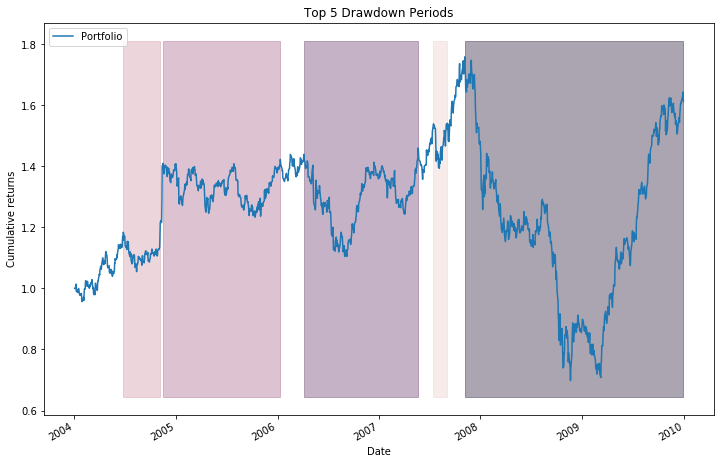

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
graph=pf.plot_drawdown_periods(returns, top=5).set_xlabel('Date')


Entire data start date: 2004-01-02
Entire data end date: 2009-12-31


Out-of-Sample Months: 2
Backtest Months: 69


Performance statistics,All history,Backtest,Out of sample
annual_return,0.08,0.08,0.04
annual_volatility,0.26,0.26,0.22
sharpe_ratio,0.44,0.43,0.28
calmar_ratio,0.14,0.13,0.51
stability_of_timeseries,-0.00,-0.08,0.23
max_drawdown,-0.60,-0.60,-0.07
omega_ratio,1.08,1.08,1.05
sortino_ratio,0.64,0.63,0.38
skew,0.21,0.22,-0.27
kurtosis,4.19,4.24,0.46


Worst Drawdown Periods,net drawdown in %,peak date,valley date,recovery date,duration
0,60.30,2007-11-06,2008-11-20,NaT,NaN
1,23.24,2006-04-06,2006-09-07,2007-05-22,294
2,12.51,2004-11-15,2005-10-12,2006-01-11,303
3,10.90,2004-06-25,2004-08-12,2004-11-04,95
4,9.47,2007-07-16,2007-08-06,2007-09-04,37




[-0.032 -0.069]


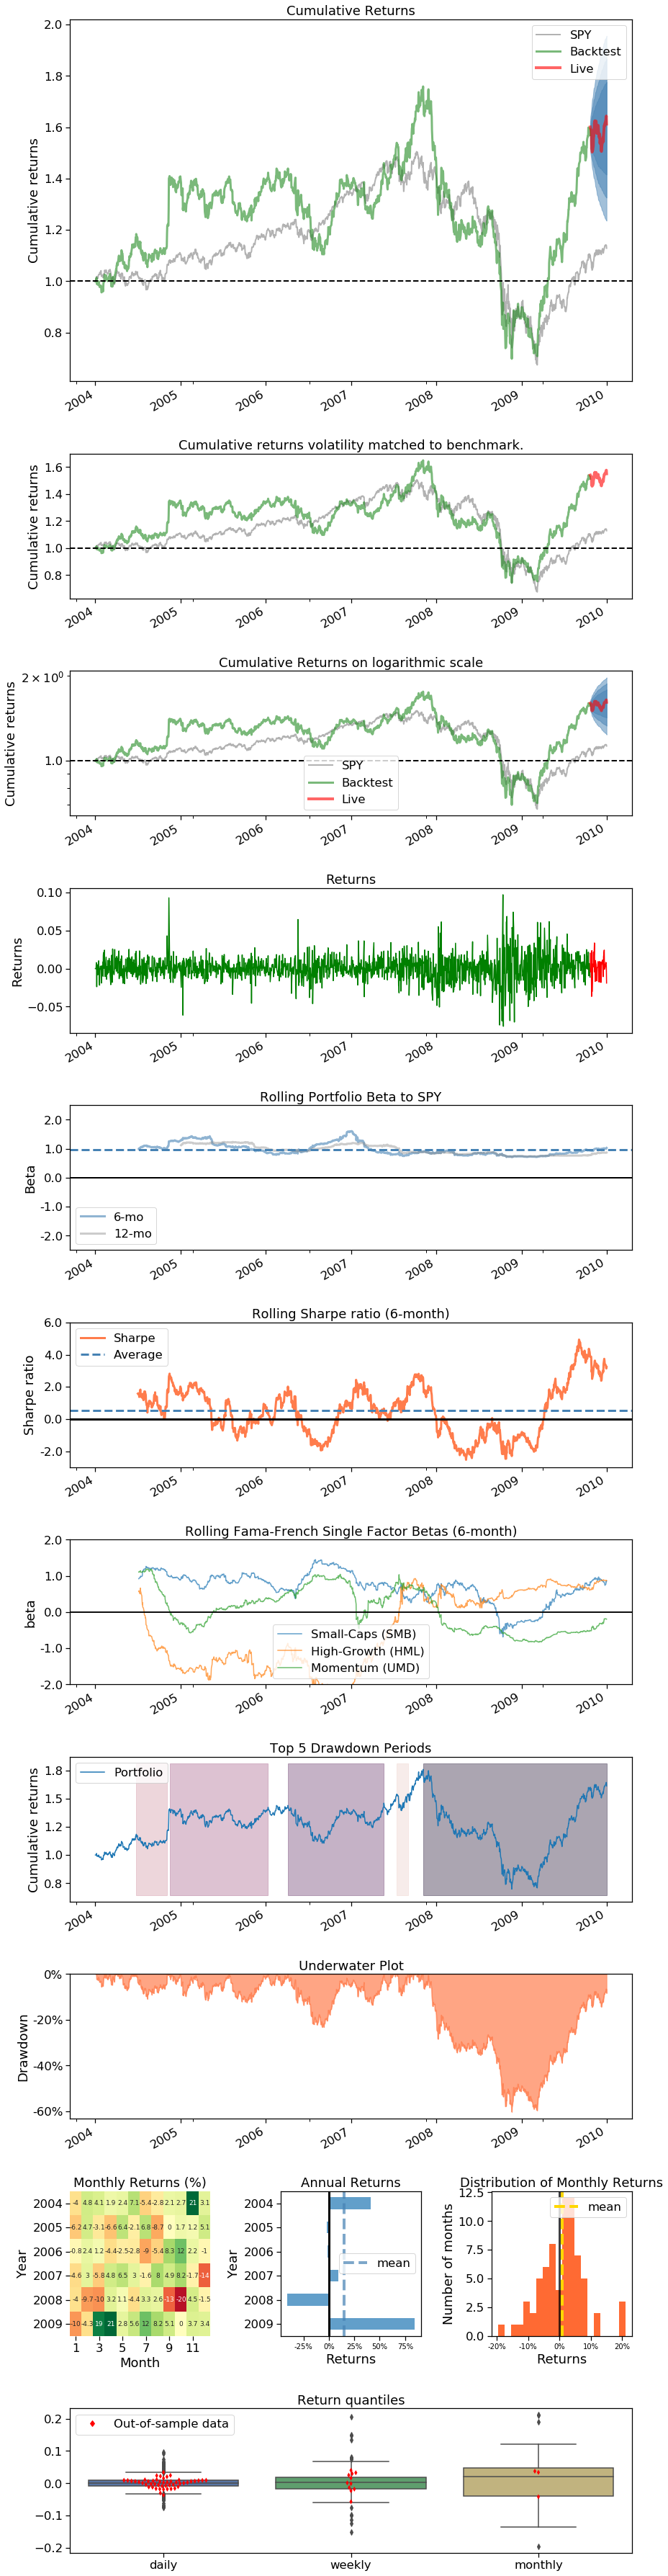

Stress Events,mean,min,max
Lehmann,-0.28%,-7.41%,4.40%
Aug07,0.35%,-2.96%,3.03%
Mar08,-0.43%,-3.10%,3.34%
Sept08,-0.68%,-7.41%,3.99%
2009Q1,-0.35%,-4.98%,3.36%
2009Q2,0.71%,-3.78%,6.17%
Low Volatility Bull Market,0.01%,-6.11%,6.45%
GFC Crash,-0.08%,-7.58%,9.71%
Recovery,0.32%,-3.78%,6.17%


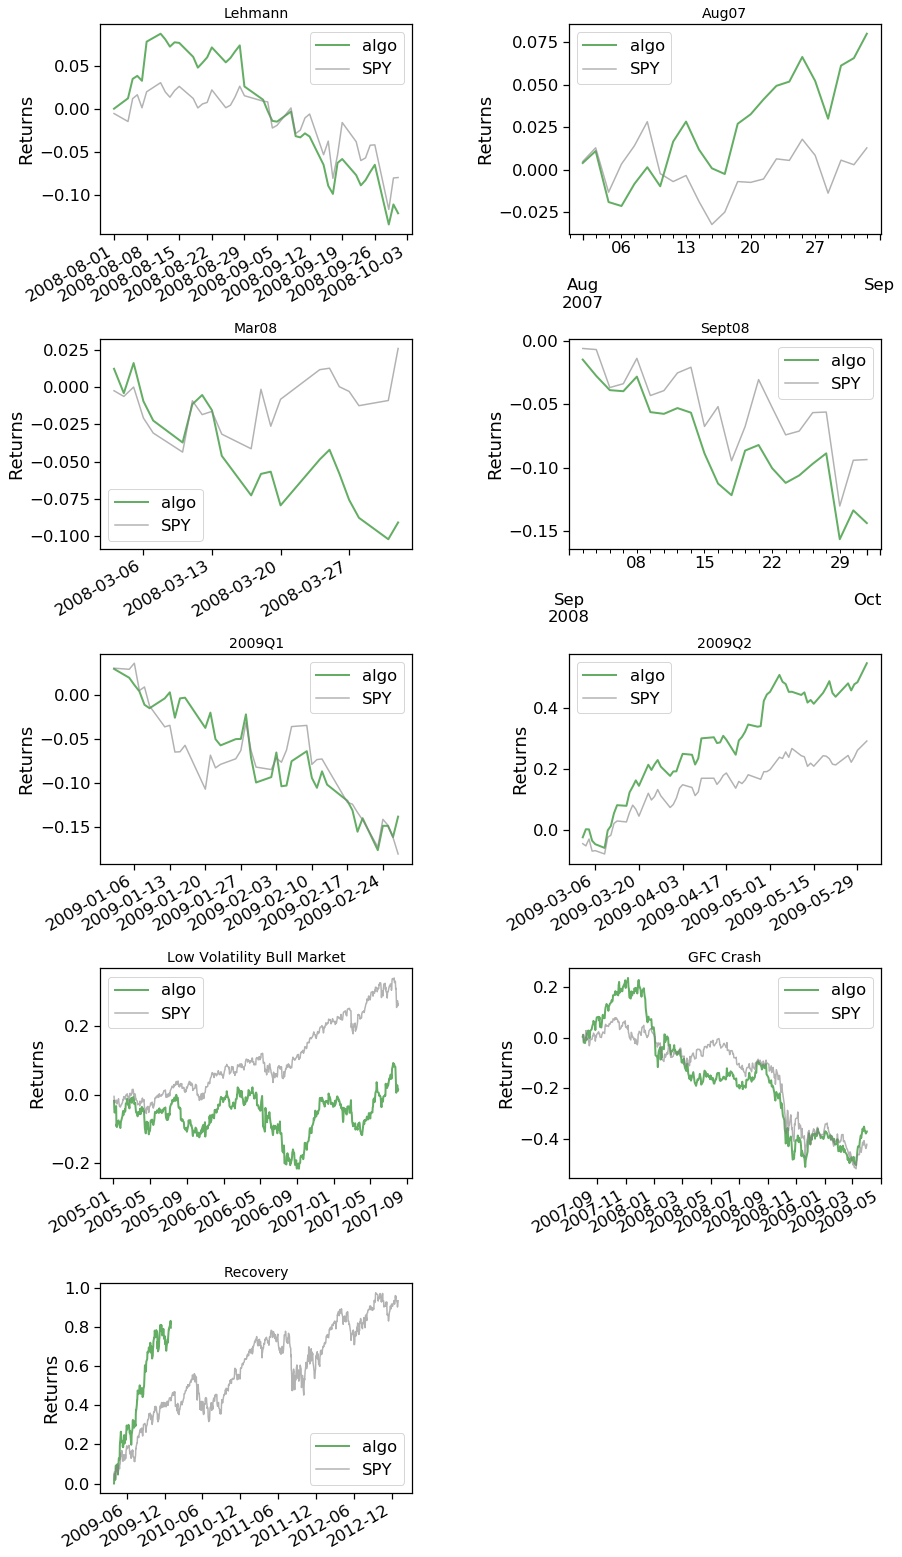

Top 10 long positions of all time,max
Equity(657 [COST]),100.74%
Equity(1847 [MMM]),92.35%
Equity(533 [CERN]),84.47%
Equity(805 [DELL]),72.76%
Equity(145 [AMD]),71.05%
Equity(1496 [INTC]),69.19%
Equity(1254 [GPS]),62.11%


Top 10 short positions of all time,max


Top 10 positions of all time,max
Equity(657 [COST]),100.74%
Equity(1847 [MMM]),92.35%
Equity(533 [CERN]),84.47%
Equity(805 [DELL]),72.76%
Equity(145 [AMD]),71.05%
Equity(1496 [INTC]),69.19%
Equity(1254 [GPS]),62.11%


All positions ever held,max
Equity(657 [COST]),100.74%
Equity(1847 [MMM]),92.35%
Equity(533 [CERN]),84.47%
Equity(805 [DELL]),72.76%
Equity(145 [AMD]),71.05%
Equity(1496 [INTC]),69.19%
Equity(1254 [GPS]),62.11%


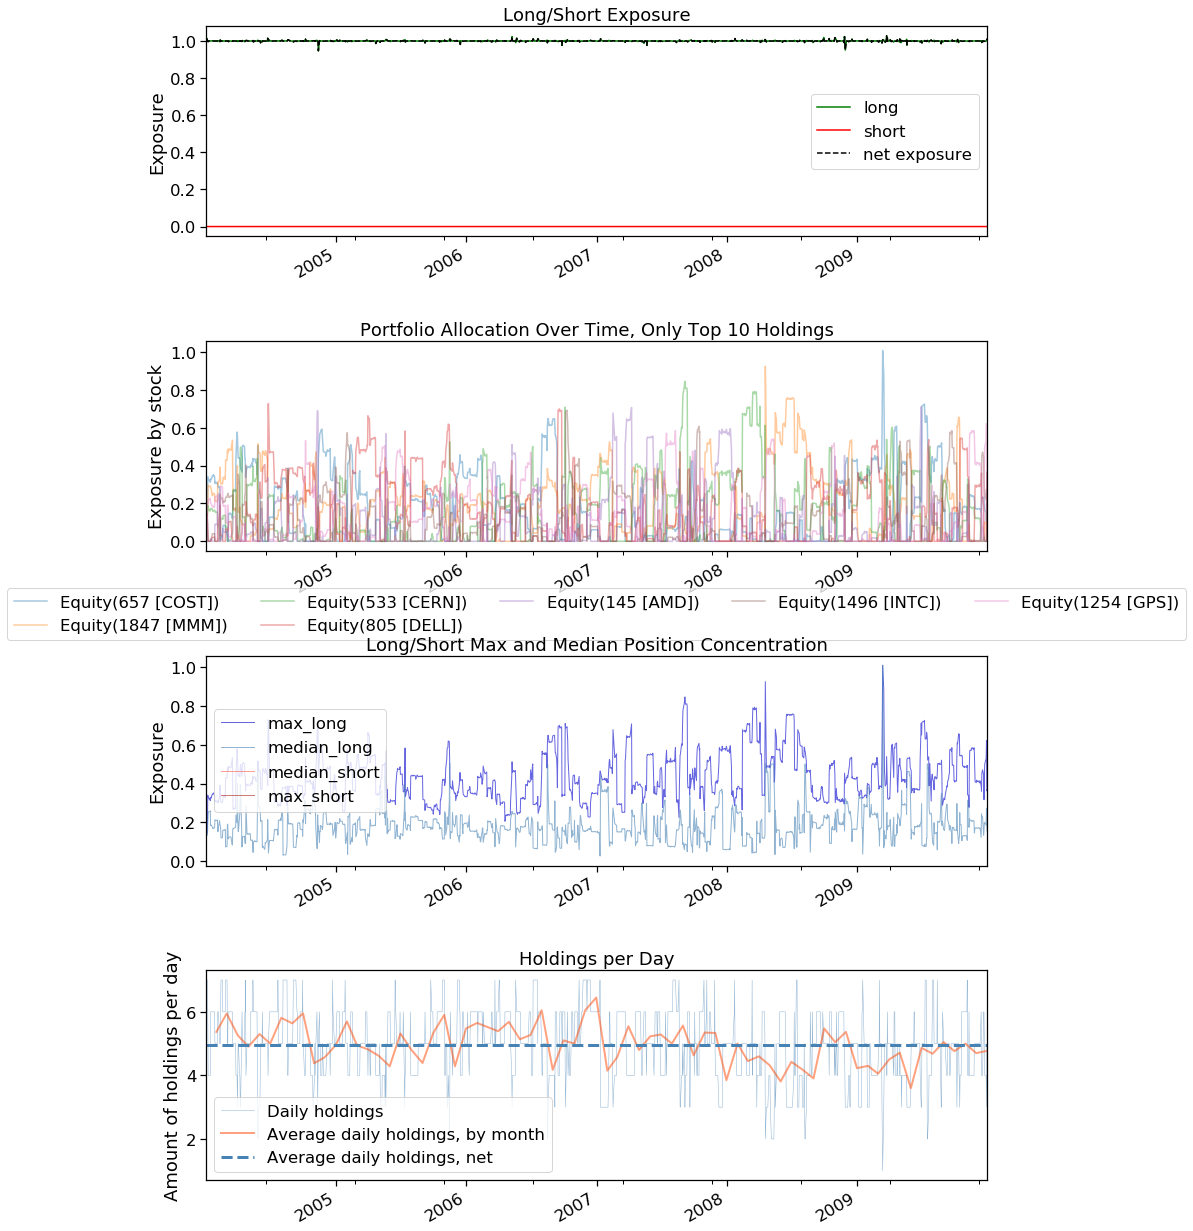

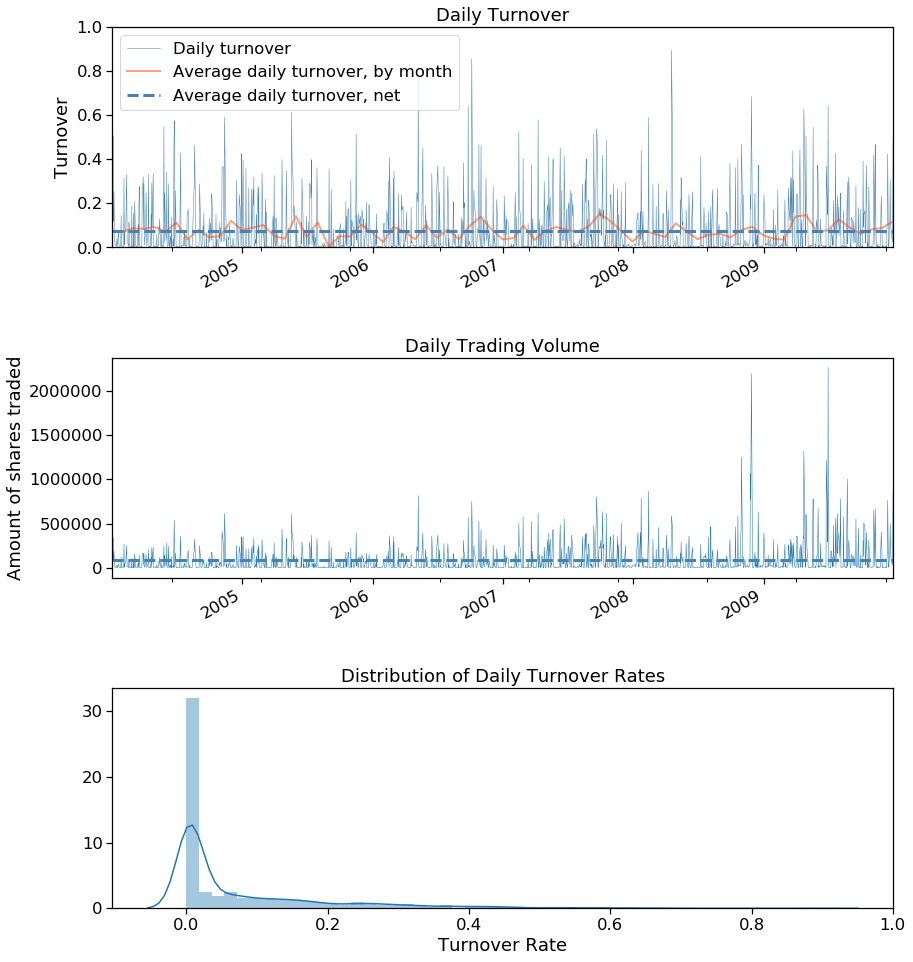

Summary stats,All trades,Long trades
Total number of round_trips,3984.00,3984.00
Percent profitable,0.49,0.49
Winning round_trips,1936.00,1936.00
Losing round_trips,2040.00,2040.00
Even round_trips,8.00,8.00


PnL stats,All trades,Long trades
Total profit,$6120677.93,$6120677.93
Gross profit,$37875038.88,$37875038.88
Gross loss,$-31754360.95,$-31754360.95
Profit factor,$1.19,$1.19
Avg. trade net profit,$1536.31,$1536.31
Avg. winning trade,$19563.55,$19563.55
Avg. losing trade,$-15565.86,$-15565.86
Ratio Avg. Win:Avg. Loss,$1.26,$1.26
Largest winning trade,$1553171.02,$1553171.02
Largest losing trade,$-1252529.24,$-1252529.24


Duration stats,All trades,Long trades
Avg duration,21 days 19:19:52.771837,21 days 19:19:52.771837
Median duration,18 days 00:00:00,18 days 00:00:00
Avg # round_trips per day,36.89,36.89
Avg # round_trips per month,774.67,774.67


Return stats,All trades,Long trades
Avg returns all round_trips,0.01%,0.01%
Avg returns winning,0.16%,0.16%
Avg returns losing,-0.13%,-0.13%
Median returns all round_trips,-0.00%,-0.00%
Median returns winning,0.02%,0.02%
Median returns losing,-0.01%,-0.01%
Largest winning trade,12.13%,12.13%
Largest losing trade,-9.14%,-9.14%


Symbol stats,Equity(145 [AMD]),Equity(533 [CERN]),Equity(657 [COST]),Equity(805 [DELL]),Equity(1254 [GPS]),Equity(1496 [INTC]),Equity(1847 [MMM])
Avg returns all round_trips,-0.00%,0.03%,0.03%,-0.03%,-0.01%,0.04%,0.01%
Avg returns winning,0.37%,0.19%,0.12%,0.13%,0.13%,0.15%,0.10%
Avg returns losing,-0.34%,-0.16%,-0.06%,-0.19%,-0.11%,-0.06%,-0.08%
Median returns all round_trips,-0.00%,0.00%,0.00%,-0.00%,-0.00%,-0.00%,-0.00%
Median returns winning,0.07%,0.02%,0.01%,0.01%,0.02%,0.03%,0.01%
Median returns losing,-0.02%,-0.01%,-0.01%,-0.01%,-0.01%,-0.00%,-0.01%
Largest winning trade,12.13%,5.94%,2.95%,3.36%,3.54%,2.33%,2.22%
Largest losing trade,-9.14%,-4.67%,-3.47%,-6.60%,-8.30%,-4.60%,-4.02%


Profitability (PnL / PnL total) per name,pnl
symbol,
Equity(1496 [INTC]),0.45%
Equity(657 [COST]),0.42%
Equity(533 [CERN]),0.36%
Equity(1847 [MMM]),0.14%
Equity(1254 [GPS]),-0.02%
Equity(145 [AMD]),-0.07%
Equity(805 [DELL]),-0.27%


<Figure size 1008x1296 with 0 Axes>

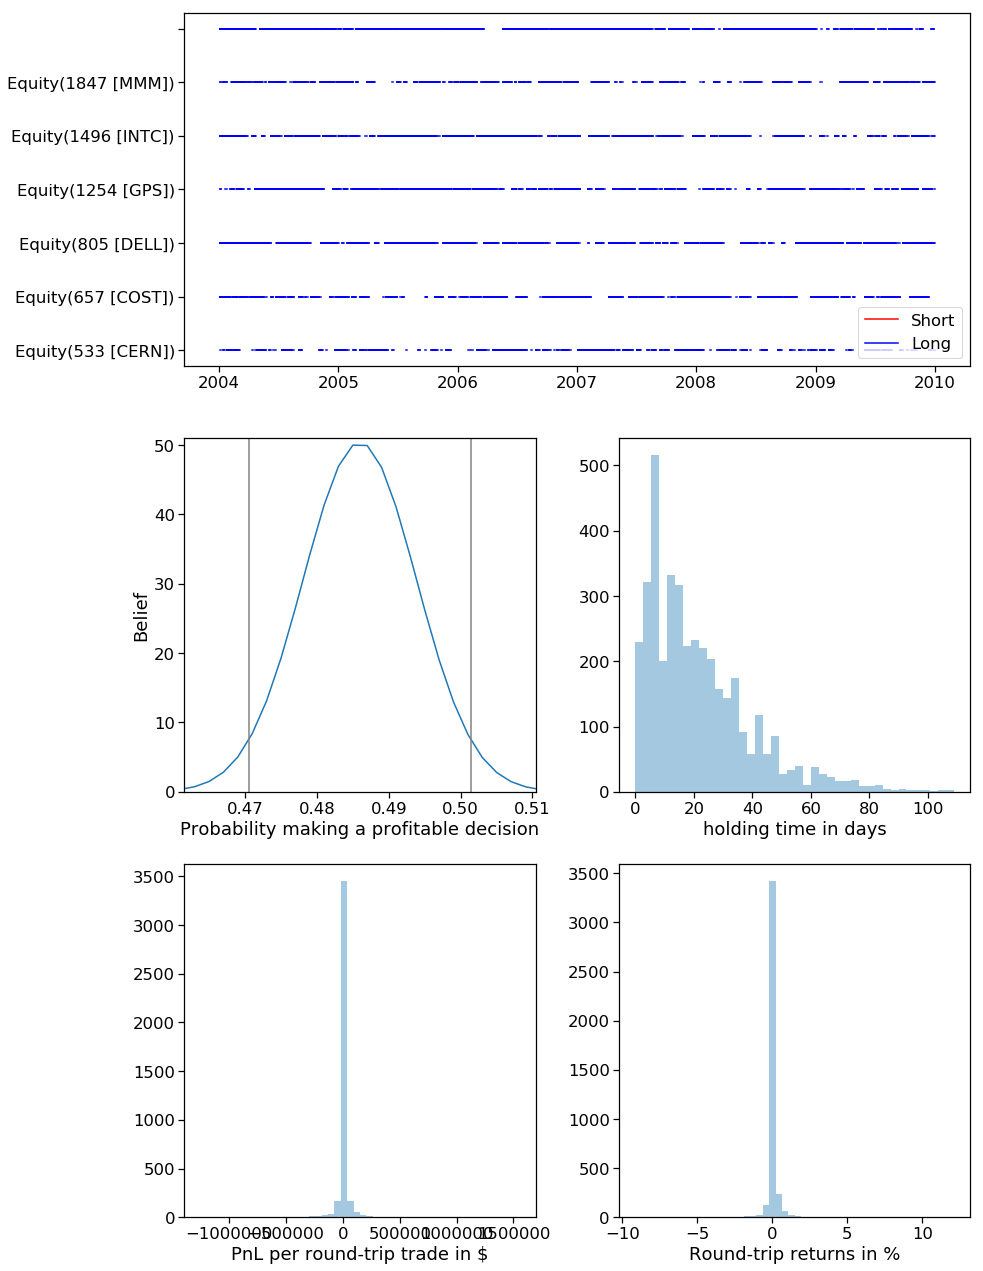

In [29]:
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions,
                          live_start_date='2009-10-22', round_trips=True)